<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Brain Observatory - Visual Behavior </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Monday, August 26, 2019</h3> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Visual Behavior Exercises Overview </h2>
    
<p> This notebook contains exercises covering several topics including behavior performance, single cell physiology and across session analysis.
  
<p> The exercises can be done in sequential order, or you can skip around to the exercises that interest you most. 
    
<p> If you get stuck, please ask a TA for help, look it up on stackoverflow, or check the solutions notebook. 
    We dont expect you to know everything already - the goal is to learn, and learning requires making mistakes and asking questions. 

<h3>Outline </h3>

<p><b>Behavior Exercises</b>
<ul><li>Exercise 1.1: Plot the distribution of reaction times for go trials from one session
<li>Exercise 1.2: Plot reward rate over time during a session
<li>Exercise 1.3: Compute and plot hit rate over time during a session
<li>Exercise 1.4: Plot the average hit rate for each image
<li>Exercise 1.5: Plot the response probability for all image transitions
</ul>
<p><b>Single Cell Physiology Exercises</b>
<ul><li>Exercise 2.1: Plot activity across stimulus repetitions using the flash response dataframe
<li>Exercise 2.2: Correlate neural activity with running speed on a flash by flash basis
<li>Exercise 2.3: Plot the trial averaged response across images for one cell using the trial response dataframe
<li>Exercise 2.4: Create a heatmap of all cells' trial averaged responses following an image change
<li>Exercise 2.5: Compute a sparseness metric for one cell
<li>Exercise 2.6: Identify image responsive cells and the mean lifetime sparseness across the population
</ul>
<p><b>Across Session Physiology Exercises</b>
<ul><li>Exercise 3.1: Follow along to learn some useful pandas tricks for multi session data comparison
<li>Exercise 3.2: Compare the activity of matched cells across sessions
<li>Exercise 3.3: Merge all the experiments from a single container and plot the mean response for different image sets
<li>Exercise 3.4: Plot the trial averaged response for passive vs. active sessions from one container
</ul>
</div>

In [1]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible automatically
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white');
sns.set_palette('deep');

In [2]:
# Import allensdk modules for loading and interacting with the data
from allensdk.brain_observatory.behavior.swdb import behavior_project_cache as bpc
# Import allensdk utilities for Visual Behavior
import allensdk.brain_observatory.behavior.swdb.utilities as tools

In [3]:
# This cell will find the appropriate path to the data based on your platform.
# You may need to edit the strings in this cell based on your configuration.

import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of the hard drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then linux (default here is for Ubuntu - insert your username; your distribution may differ)
    data_root = "/media/$USERNAME/Brain2019"
    
cache_path = os.path.join(data_root, 'dynamic-brain-workshop/visual_behavior/2019')

In [ ]:
cache = bpc.BehaviorProjectCache(cache_path)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Pick an experiment session based on its <code>cre_line</code>, <code>imaging_depth</code> and <code>stage_name</code></b>

<p>1) Filter the experiments table according to your metadata of interest and get the <code>ophys_experiment_id</code> for a session of your choosing. 
    
<p>Hint: use pandas Boolean indexing to filter by multiple column values.
    
 __[Documentation for Boolean indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)__


In [4]:
experiments = cache.experiment_table

In [5]:
selected_experiments = experiments[(experiments.full_genotype=='Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt')&
        (experiments.imaging_depth==175) & (experiments.stage_name=='OPHYS_4_images_B')]
selected_experiments

,ophys_experiment_id,container_id,full_genotype,cre_line,imaging_depth,targeted_structure,image_set,stage_name,passive_session,animal_name,sex,date_of_acquisition,retake_number
3,795953296,791352433,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Vip-IRES-Cre,175,VISp,B,OPHYS_4_images_B,False,744911447,F,2018-12-14 20:17:05,0.0
30,805784331,814797528,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Vip-IRES-Cre,175,VISp,B,OPHYS_4_images_B,False,760949537,M,2019-01-08 16:11:18,1.0
36,830093338,825183217,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Vip-IRES-Cre,175,VISp,B,OPHYS_4_images_B,False,791756316,M,2019-02-27 16:09:43,0.0


In [6]:
experiment_id = selected_experiments.ophys_experiment_id.values[0]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>Load the session object for your experiment

</div>

In [7]:
session = cache.get_session(experiment_id)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Exercises</h2>

<p> This set of exercises explores basic behavior metrics, using the 'trials' dataframe. The 'trials' dataframe is organized around the times of stimulus identity changes (go trials) and sham change times (catch trials). It contains data and metadata for each trial, including lick times, reward times, and image identity.
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.1: Plot the distribution of reaction times for go trials from one session</b>

<p> 1) get the <code>trials</code> dataframe from the session object. 
    
<p> 2) Filter the trials dataframe to get go trials only. 
    
<p> 3) Use the values of the <code>response_latency</code> column to plot a histogram of reaction times. 
    
<p> <code>response_latency</code> is the first lick time, in seconds, relative to the change time. 
    
</div>

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'time after change (sec)')

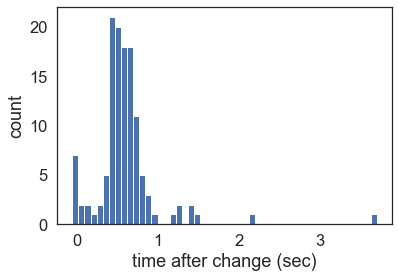

In [8]:
trials = session.trials.copy()
plt.hist(trials[trials.go==True].response_latency.values, bins=50);
plt.ylabel('count')
plt.xlabel('time after change (sec)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2: Plot reward rate over time during a session</b>

<p> 1) Use the <code>reward_rate</code> and <code>change_time</code> columns of the trials dataframe to plot reward rate over time. 
    
<p> The <code>reward rate</code> on each trial has been pre-computed as the number of rewards per minute, over a 25 trial rolling window. 
   
<p> Was the mouse actively performing the task and earning rewards during the entire session? 
    
</div>

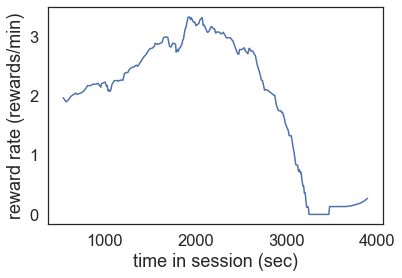

In [9]:
trials = session.trials.copy()
plt.plot(trials.change_time, trials.reward_rate)
plt.xlabel('time in session (sec)');
plt.ylabel('reward rate (rewards/min)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3: Compute and plot hit rate over time during a session</b>

<p> 1) Filter the trials dataframe to get the <code>response_binary</code> column for <code>go</code> trials only. Assign this to a new variable called <code>go_responses</code> for further computation. Note: Make sure that you get <code>go_responses</code> as a pandas series, without calling <code>.values</code>, so that the next step will work properly. 
    
<p> The <code>response_binary</code> column of the trials dataframe contains a 1 for all trials where there was a licking response within the 750ms reward window and a 0 where there was not. 

<p> 2) Apply the pandas <code>rolling()</code> method to <code>go_responses</code> followed by <code>.mean()</code> to take a rolling mean across across go trials. Set <code>window = 25, center = True</code> in the call to <code>rolling()</code> for a centered window over 25 trials. Set the output of this step to a variable called <code>rolling_hit_rate</code>. 

 __[Documentation for pandas.rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)__
       
</div>

In [10]:
go_responses = trials[trials['go']==True].response_binary
rolling_hit_rate = go_responses.rolling(window=25, center=True).mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 3) Plot the <code>rolling_hit_rate</code>. Label your axes.
       
</div>

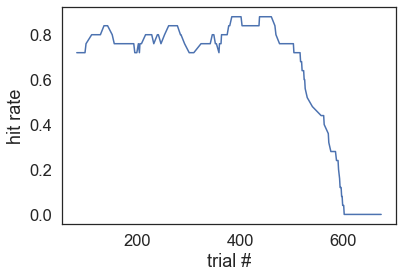

In [11]:
plt.plot(rolling_hit_rate)
plt.xlabel('trial #')
plt.ylabel('hit rate');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4: Plot the average hit rate for each image</b>

<p>1) Loop through the 8 images in this session and quantify the fraction of go trials where there was a correct response for each image to get the mean hit rate across the session. 
    Hint: Use <code>session.trials.change_image_name.unique()</code> to get the image names.

<p>2) Plot the average hit rate for each image, with image names along the x-axis. 
    
<p> Bonus: Sort hit rate values in ascending order and apply the same sorting to the image names along the x-axis. Hint: Useful functions include np.sort() and np.argsort()
    
</div>

In [12]:
# get the hit rate for each image
hit_rates = []
images = session.trials.change_image_name.unique()
for image in images:
    image_change_trials = session.trials[(session.trials.change_image_name == image) & session.trials.go]
    hit_rates.append(np.sum(image_change_trials.hit)/len(image_change_trials))

In [13]:
# sort the hit rates in ascending order and sort the image labels in the same order
hit_rates_sorted = np.sort(hit_rates)
sorted_order = np.argsort(hit_rates)
images_sorted = images[sorted_order]

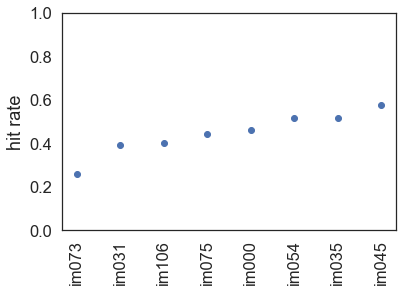

In [14]:
# plot hit rate by image with image names on the x-axis
fig, ax = plt.subplots()
plt.plot(hit_rates_sorted, 'o')
ax.set_xticks(np.arange(0,len(images_sorted),1));
ax.set_xticklabels(images_sorted, rotation=90);
ax.set_ylabel('hit rate');
ax.set_ylim(0,1);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5: Plot the response probability for all image transitions</b>

<p> The task cycles through 8 different images, resulting in 64 possible image transitions. Some image transitions might be easier for the mouse to detect than others. 

<p> 1) Use pandas <code>pivot_table</code> on the trials table to aggregate and average the <code>response_binary</code> values by <code>initial_image_name</code> and <code>change_image_name</code>. This will create a matrix of response probability for all image transitions. 
    
 __[Documentation for pandas.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)__ 
 
</div>

In [15]:
# use pivot table to make a matrix of respones probability
response_matrix = pd.pivot_table(trials,  
                                 values='response_binary', 
                                 index=['initial_image_name'],
                                 columns=['change_image_name'])
response_matrix

change_image_name,im000,im031,im035,im045,im054,im073,im075,im106
initial_image_name,,,,,,,,
im000,0.000000,0.25,0.50,0.500000,0.500000,0.00,0.666667,0.000000
im031,0.500000,0.50,0.25,0.500000,0.500000,0.25,0.250000,0.250000
im035,0.500000,0.50,0.25,0.666667,0.750000,0.25,0.500000,0.666667
im045,0.666667,0.00,0.50,0.333333,0.500000,0.00,0.500000,0.500000
im054,0.666667,0.50,0.25,0.500000,0.250000,0.25,0.500000,0.500000
im073,0.250000,0.50,0.50,0.500000,0.250000,0.25,0.250000,0.666667
im075,0.250000,0.50,0.75,0.500000,0.500000,0.50,0.000000,0.333333
im106,0.500000,0.50,1.00,1.000000,0.666667,0.50,0.500000,0.000000


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Plot the hit transition matrix as a heatmap. Try using seaborn's heatmap function.

 __[Documentation for seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap)__ 
    

<p> Did the mouse respond similarly for image changes compared to the same image repeated on catch trials? Are some image transitions more detectable than others? 

</div>

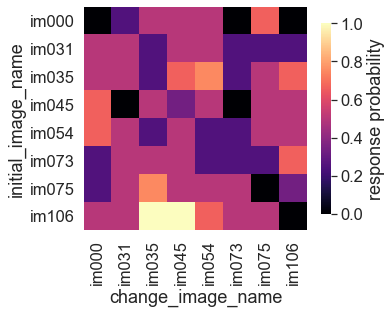

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>Bonus: Plot response probability across image transitions for engaged trials only


<p> 1) Filter out trials where the mouse wasn't reliably performing the task using the value of the <code>reward_rate</code> column, with a threshold of 2 rewards per minute to distinguish engaged from disengaged periods, then plot the transition heatmap again. 

<p> Does varying engagement influence how we should analyze neural activity?

</div>

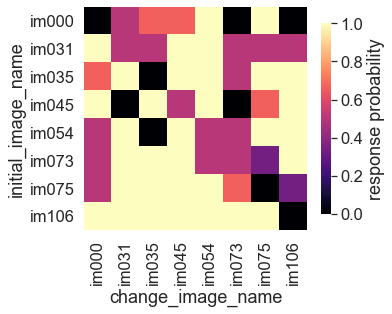

In [17]:
response_matrix = pd.pivot_table(trials[trials.reward_rate>2],  
                                 values='response_binary', 
                                 index=['initial_image_name'],
                                 columns=['change_image_name'])

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Single Cell Physiology Exercises</h2>
    
<p> These exercises explore neural activity aligned to trials or to all stimulus flashes. They make use of the 'trial_response_df' and 'flash_response_df' dataframes that have been pre-computed for you, after temporal alignment between ophys and stimulus data streams. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p><b>Info about trial and flash response dataframes</b>
    
<p> The <code>trial_response_df</code> contains the response of each cell to each behavioral trial during the task.  
    
<p> The <code>flash_response_df</code> contains the response of each cell to each individual stimulus presentation during the session. 
    
<p> Both dataframes have a column called <code>dff_trace</code> that contains a segment of each cell's fluorescence trace over a window of time. For the <code>trial_response_df</code> this window is [-4,8] seconds relative to the <code>change_time</code> for each trial. For the <code>flash_response_df</code> this window is [-0.5, 0.75] seconds relative to the stimulus <code>start_time</code> for for each flash. 
    
<p> The duration of the window over which the <code>dff_trace</code> was extracted can be found in the <code>analysis_files_metadata</code> attribute of the cache object. 
    
<p> Both dataframes also have a column called <code>mean_response</code> that contains each cell's response averaged over  500ms after the <code>change_time</code> or the <code>start_time</code>. The period of time used for averaging to get the <code>mean_response</code> is also stored in the <code>analysis_files_metadata</code> attribute of the cache object. 
    
<p> Examine the <code>analysis_files_metadata</code> to get a better understanding of how <code>trial_response_df</code> and <code>flash_response_df</code> were created. 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Examine the <code>analysis_files_metadata</code> to get a better understanding of how <code>trial_response_df</code> and <code>flash_response_df</code> were created. 

</div>

In [18]:
# examine the metadata in the cache object
cache.analysis_files_metadata

{'ophys_frame_rate': 31,
 'trial_response_df_params': {'window_around_timepoint_seconds': [-4, 8],
  'response_window_duration_seconds': 0.5,
  'baseline_window_duration_seconds': 0.5},
 'flash_response_df_params': {'window_around_timepoint_seconds': [-0.5, 0.75],
  'response_window_duration_seconds': 0.5,
  'baseline_window_duration_seconds': 0.5}}

In [19]:
# get the window relative to the 'change_time' that is used to create the 'dff_trace' column of the 'trial_response_df'
print('window relative to change_time for dff_traces in trial_response_df =', 
      cache.analysis_files_metadata['trial_response_df_params']['window_around_timepoint_seconds'],
     'relative to change_time')

window relative to change_time for dff_traces in trial_response_df = [-4, 8] relative to change_time


In [20]:
# get the window relative to the 'start_time' that is used to create the 'dff_trace' column of the 'flash_response_df'
print('window for dff_traces in flash_response_df =', 
      cache.analysis_files_metadata['flash_response_df_params']['window_around_timepoint_seconds'],
     'relative to start_time')

window for dff_traces in flash_response_df = [-0.5, 0.75] relative to start_time


In [21]:
# what is the duration of time used for averaging to create the 'mean_response' column of either dataframe? 
print('duration of mean_response window =',
      cache.analysis_files_metadata['flash_response_df_params']['response_window_duration_seconds'])

duration of mean_response window = 0.5


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.1: Plot activity across stimulus repetitions using the flash response dataframe</b>

<p> 1) Assign session.flash_response_df to a variable called <code>fr</code>. Use .copy() when you assign the variable to avoid accidentally changing values of the original dataframe. 

<p> 2) Pick a cell and get all flashes of the preferred image for that cell by filtering <code>fr</code> by both the <code>cell_specimen_id</code> column and the <code>pref_stim</code> column. The preferred stimulus for each cell was pre-computed as the image that evoked the largest average response for that cell.

</div>

In [22]:
# assign flash_response_df to a shorter variable name
fr = session.flash_response_df.copy()

In [23]:
fr

,cell_specimen_id,flash_id,dff_trace,dff_trace_timestamps,mean_response,baseline_response,p_value,pref_stim,image_name,image_index,...,rewards,mean_running_speed,absolute_flash_number,time_from_last_lick,time_from_last_reward,time_from_last_change,block_index,image_block_repetition,repeat_within_block,image_set
0,817101771,0,"[-0.044880189857227734, 0.3673726291285746, 0....","[306.47157, 306.50389, 306.53621, 306.56853, 3...",0.026133,-0.001952,0.3003,False,im000,0,...,[],28.336079,0,11.07744,NaN,NaN,0,0,0.0,B
1,817101771,1,"[0.06773741189529763, 0.15776891936522314, 0.0...","[307.21492, 307.24724, 307.27956, 307.31188, 3...",0.094365,0.012433,0.1339,False,im000,0,...,[],3.207096,1,0.08514,NaN,NaN,0,0,1.0,B
2,817101771,2,"[0.28044997338115546, 0.5378372092356751, 0.21...","[307.99059, 308.02291, 308.05523, 308.08755, 3...",0.254184,0.095029,0.0402,False,im000,0,...,[],27.343649,2,0.83573,NaN,NaN,0,0,2.0,B
3,817101771,3,"[0.4186494112063733, 0.3693774565292788, 0.305...","[308.73394, 308.76626, 308.79858, 308.83089, 3...",0.040240,0.263462,0.2382,False,im000,0,...,[],9.276159,3,1.58647,NaN,NaN,0,0,3.0,B
4,817101771,4,"[0.28571362544447143, 0.1626243617862052, 0.26...","[309.47729, 309.5096, 309.54192, 309.57424, 30...",0.213133,-0.011465,0.0528,False,im000,0,...,[],19.178142,4,2.33694,NaN,NaN,0,0,4.0,B
5,817101771,5,"[0.2613162535810314, 0.7063454359013727, 0.400...","[310.22063, 310.25295, 310.28527, 310.31759, 3...",0.401857,0.250229,0.0240,False,im000,0,...,[],27.957444,5,3.08759,NaN,NaN,0,0,5.0,B
6,817101771,6,"[0.8047086572648389, 0.7449388665286857, 0.636...","[310.96398, 310.9963, 311.02862, 311.06094, 31...",0.106703,0.423017,0.1218,False,im000,0,...,[],20.389777,6,3.83820,NaN,NaN,0,0,6.0,B
7,817101771,7,"[0.23286088005693262, 0.04148817098050045, 0.1...","[311.73965, 311.77197, 311.80429, 311.83661, 3...",0.144460,-0.074761,0.0859,False,im000,0,...,[],27.971547,7,4.58881,NaN,NaN,0,0,7.0,B
8,817101771,8,"[0.4609168563024715, 0.3914562708535613, 0.042...","[312.483, 312.51532, 312.54764, 312.57996, 312...",-0.069563,0.084267,0.9679,False,im000,0,...,[],6.561848,8,0.15178,NaN,NaN,0,0,8.0,B
9,817101771,9,"[-0.17722408263376538, -0.17133630955092688, 0...","[313.22635, 313.25867, 313.29099, 313.32331, 3...",0.163387,-0.055280,0.0746,False,im000,0,...,[],22.940661,9,0.90210,NaN,NaN,0,0,9.0,B


In [24]:
# get all flashes of preferred image for one cell
cell_specimen_ids = fr.cell_specimen_id.unique()
cell_specimen_id = cell_specimen_ids[0]

pref_stim_flashes = fr[(fr.cell_specimen_id==cell_specimen_id)&(fr.pref_stim==True)]
pref_stim_flashes.head()

,cell_specimen_id,flash_id,dff_trace,dff_trace_timestamps,mean_response,baseline_response,p_value,pref_stim,image_name,image_index,...,rewards,mean_running_speed,absolute_flash_number,time_from_last_lick,time_from_last_reward,time_from_last_change,block_index,image_block_repetition,repeat_within_block,image_set
41,817101771,41,"[0.504253135155179, 0.05801686764158642, 0.114...","[337.23982, 337.27214, 337.30446, 337.33678, 3...",0.174112,0.043819,0.0699,True,im054,5,...,[],35.493028,41,5.28938,NaN,0.051431,2,0,0.0,B
42,817101771,42,"[0.6661682561784421, 0.4434622952114722, 0.322...","[338.01549, 338.04781, 338.08013, 338.11245, 3...",-0.059540,0.123065,0.9396,True,im054,5,...,[],5.743842,42,0.00169,NaN,0.802041,2,0,1.0,B
43,817101771,43,"[-0.046788922193049504, -0.167131588254453, 0....","[338.75885, 338.79117, 338.82348, 338.8558, 33...",-0.018772,-0.120907,0.6694,True,im054,5,...,[],29.536398,43,0.75231,NaN,1.552661,2,0,2.0,B
44,817101771,44,"[0.1546256848152657, 0.033992372301075435, 0.2...","[339.5022, 339.53452, 339.56684, 339.59916, 33...",0.170322,-0.065638,0.0715,True,im054,5,...,[],27.645912,44,1.50291,NaN,2.303261,2,0,3.0,B
45,817101771,45,"[0.8628415645787145, 0.2852896080620359, 0.517...","[340.24555, 340.27787, 340.31019, 340.34251, 3...",0.136364,0.164448,0.0931,True,im054,5,...,[],34.889856,45,2.25393,NaN,3.054281,2,0,4.0,B


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Get the values of the <code>dff_trace</code> column from your filtered dataframe. Loop through these values and plot the traces for all flashes of the preferred image. Set color='gray. 
    
Bonus: Plot with time relative to the stimulus onset, in seconds, on the x-axis. Hint: Use the <code>dff_trace_timestamps</code> and <code>start_time</code> columns to get time relative to stimulus onset for one flash.
    
<p> 4) Take the mean of the <code>dff_trace</code> values and plot the average response on the same figure as the individual trials, this time setting color='b'.

Does this cell have a reliable response to its preferred image? 

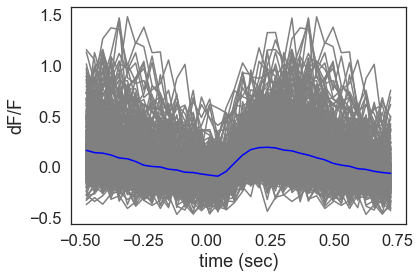

In [25]:
# plot for one cell
time_seconds = fr.iloc[0].dff_trace_timestamps  - fr.iloc[0].start_time
for trace in pref_stim_flashes.dff_trace.values: 
    plt.plot(time_seconds, trace, color='gray')
plt.xlabel('time (sec)')
plt.ylabel('dF/F')
mean_trace = np.mean(pref_stim_flashes.dff_trace.values)
plt.plot(time_seconds, mean_trace, color='b');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">   

<p> 5) Create this plot for multiple cells. How do different cells respond?
    
Bonus: Plot multiple cells in one figure on different axes. Use <code>fig, ax = plt.subplots()</code> followed by <code>ax = ax.ravel()</code> to create iterable axes. 

 __[Documentation for matplotlib.pyplot.subplots()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html)__ 
    
 __[Why use fig, ax = plt.subplots() ? ](https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python )__ 

</div>

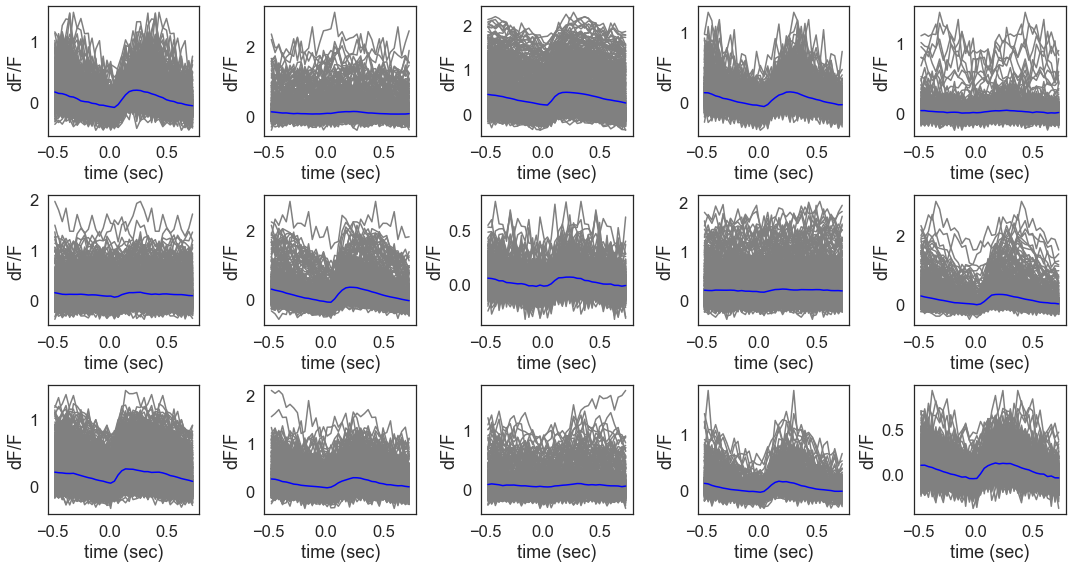

In [26]:
# plot for 15 cells
cell_specimen_ids = fr.cell_specimen_id.unique()
fig, ax = plt.subplots(3,5, figsize=(15,8))
ax = ax.ravel()
for i,cell_specimen_id in enumerate(cell_specimen_ids[:15]): 
    pref_stim_flashes = fr[(fr.cell_specimen_id==cell_specimen_id)&(fr.pref_stim==True)]
    time_seconds = fr.iloc[0].dff_trace_timestamps  - fr.iloc[0].start_time
    for trace in pref_stim_flashes.dff_trace.values: 
        ax[i].plot(time_seconds, trace, color='gray')
    ax[i].set_xlabel('time (sec)')
    ax[i].set_ylabel('dF/F')
    mean_trace = np.mean(pref_stim_flashes.dff_trace.values)
    ax[i].plot(time_seconds, mean_trace, color='b')
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.2: Correlate neural activity with running speed on a flash by flash basis</b>

<p> Trial to trial variability could arise from differences in animal behavior. One possibility is modulation by running speed. 

<p> 1) Pick a cell and select all flashes of its preferred stimulus. 
    
<p> 2) Create a scatterplot of running speed vs neural response magnitude using the <code>mean_response</code> and <code>mean_running_speed</code> columns of the <code>flash_response_df</code>. 

<p> The <code>mean_running_speed</code> is the average of the running_speed trace during the 250ms stimulus presentation for each image flash. 
    
</div>

In [27]:
fr = session.flash_response_df.copy()

In [28]:
# get preferred stimulus flashes for one cell
cell_specimen_ids = fr.cell_specimen_id.unique()
cell_specimen_id = cell_specimen_ids[4]

pref_stim_flashes = fr[(fr.cell_specimen_id==cell_specimen_id)&(fr.pref_stim==True)]
pref_stim_flashes.head()

,cell_specimen_id,flash_id,dff_trace,dff_trace_timestamps,mean_response,baseline_response,p_value,pref_stim,image_name,image_index,...,rewards,mean_running_speed,absolute_flash_number,time_from_last_lick,time_from_last_reward,time_from_last_change,block_index,image_block_repetition,repeat_within_block,image_set
19200,817103270,28,"[-0.033364458999941025, -0.024739016643175814,...","[327.47929, 327.51161, 327.54393, 327.57625, 3...",0.070494,-0.086219,0.2711,True,im073,3,...,[],31.684745,28,15.16373,NaN,0.051507,1,0,0.0,B
19201,817103270,29,"[-0.02793199456183633, 0.32243739835905644, 0....","[328.25496, 328.28728, 328.3196, 328.35192, 32...",0.068876,0.088681,0.2751,True,im073,3,...,[],40.637921,29,15.91470,NaN,0.802477,1,0,1.0,B
19202,817103270,30,"[0.2095509836308945, 0.2782990771772758, 0.078...","[328.99831, 329.03063, 329.06295, 329.09527, 3...",0.111644,0.019610,0.1978,True,im073,3,...,[],37.899287,30,16.66524,NaN,1.553017,1,0,2.0,B
19203,817103270,31,"[0.17484316901596347, 0.20180169891215854, 0.2...","[329.74166, 329.77398, 329.8063, 329.83862, 32...",0.112508,0.078992,0.1967,True,im073,3,...,[],37.551458,31,17.41554,NaN,2.303317,1,0,3.0,B
19204,817103270,32,"[0.22086497376373782, 0.1572113463725412, 0.35...","[330.48502, 330.51734, 330.54965, 330.58197, 3...",0.118793,0.095635,0.1871,True,im073,3,...,[],45.352404,32,18.16618,NaN,3.053957,1,0,4.0,B


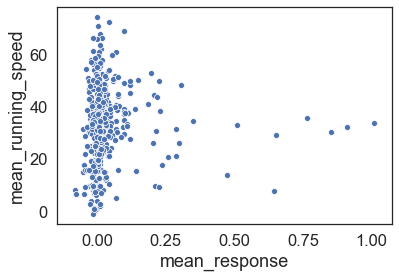

In [29]:
# plot scatter plot of mean response vs. running speed
fig, ax = plt.subplots()
ax = sns.scatterplot(data=pref_stim_flashes, x='mean_response', y='mean_running_speed', ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Compute the Pearson correlation between the flash-wise <code>mean_response</code> and <code>mean_running_speed</code> using <code>scipy.stats.pearsonr()</code>. Is there a correlation? 

</div>

In [30]:
# get pearson correlation 
import scipy.stats as st
r, p = st.pearsonr(pref_stim_flashes['mean_response'].values, pref_stim_flashes['mean_running_speed'].values)
print('r = ', np.round(r,3))

r =  -0.002


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Bonus: Compute the running correlation for all cells in the session and plot a histogram of the values. 

</div>

In [31]:
# get pearson correlation values for all cells
r_values = []
for cell_specimen_id in cell_specimen_ids:
    pref_stim_flashes = fr[(fr.cell_specimen_id==cell_specimen_id)&(fr.pref_stim==True)]
    r, p = st.pearsonr(pref_stim_flashes['mean_response'].values, pref_stim_flashes['mean_running_speed'].values)
    r_values.append(r)

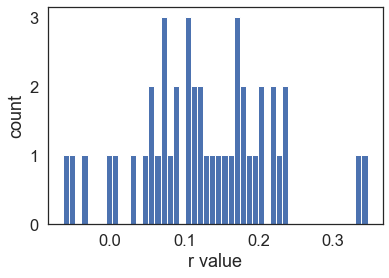

In [32]:
# plot distribution of pearson r values
plt.hist(r_values, bins=50);
plt.xlabel('r value');
plt.ylabel('count');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.3: Plot the trial averaged response across images for one cell using the trial response dataframe</b>
   
<p> 1) Assign the <code>trial_response_df</code> to a variable called <code>tr</code>. Dont forget to use <code>.copy()</code>
    
<p> 2) Which cell had the largest <code>mean_response</code>? What image was shown on that trial? Was it a go trial or a catch trial?  
    
</div>

In [33]:
# get trial_response_df
tr = session.trial_response_df.copy()

In [34]:
# get the trial with the largest value of mean_response
max_response_trial = tr[tr.mean_response==np.amax(tr.mean_response)]
# get info for that trial
cell_specimen_id = max_response_trial.cell_specimen_id.values[0]
change_image_name = max_response_trial.change_image_name.values[0]
go = max_response_trial.go.values[0]
catch = max_response_trial.catch.values[0]
# display info
print('cell_specimen_id: ' + str(cell_specimen_id))
print('change_image_name: ' + str(change_image_name))
print('go trial: ' + str(go))
print('catch trial: ' + str(catch))

cell_specimen_id: 817106409
change_image_name: im054
go trial: False
catch trial: True


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Plot the average <code>dff_trace</code> across trials for the cell, image name, and trial type identified in the step above. Plot the x-axis in seconds relative to the <code>change_time</code>. 
    
Bonus: Show the the time of the change flash (from 0 to .25 seconds after the change time) using ax.vspan(). 
</div>

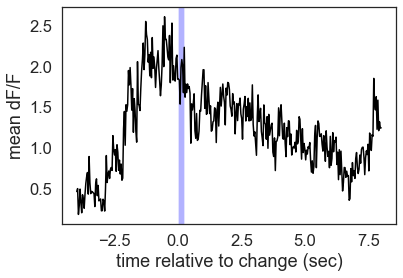

In [35]:
# plot the trial averaged trace for the conditions identified above
cell_data = tr[(tr.cell_specimen_id==cell_specimen_id)&(tr.change_image_name==change_image_name)&(tr.go==go)]
mean_trace = cell_data.dff_trace.mean()
timestamps = tr.iloc[0].dff_trace_timestamps  - tr.iloc[0].change_time
plt.plot(timestamps ,mean_trace, 'k')
plt.axvspan(0, 0.25 ,alpha=0.3,facecolor='blue')
plt.ylabel('mean dF/F');
plt.xlabel('time relative to change (sec)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
 
<p> 4) Loop through the 8 images shown in this session and plot the average dF/F trace for each image for this cell.
    
</div>

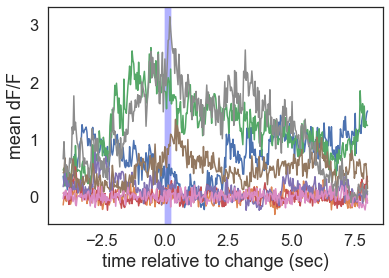

In [36]:
unique_images = tr.change_image_name.unique()
for change_image_name in unique_images:
    cell_data = tr[(tr.cell_specimen_id==cell_specimen_id)&(tr.change_image_name==change_image_name)&(tr.go==go)]
    mean_trace = cell_data.dff_trace.mean()
    plt.plot(timestamps, mean_trace)
plt.axvspan(0, 0.25, alpha=0.3, facecolor='blue')
plt.ylabel('mean dF/F')
plt.xlabel('time relative to change (sec)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.4: Create a heatmap of all cells' trial averaged responses following an image change</b>

<p> The SDK has utilities functions to make some computations easier. Import the utilities using the code below, then run help() on the function <code>get_mean_df</code>. What are it's inputs and outputs? 
    
</div>

In [37]:
# import SDK utilities 
import allensdk.brain_observatory.behavior.swdb.utilities as tools

help(tools.get_mean_df)

Help on function get_mean_df in module allensdk.brain_observatory.behavior.swdb.utilities:

get_mean_df(response_df, conditions=['cell_specimen_id', 'image_name'])
    Computes an analysis on a selection of responses (either flashes or trials). Computes mean_response, sem_response, the pref_stim, fraction_active_responses.
    
    INPUTS
    response_df: the dataframe to group
    conditions: the conditions to group by, the first entry should be 'cell_specimen_id', the second could be 'image_name' or 'change_image_name'
    
    OUTPUTS:
    mdf: a dataframe with the following columns:
        mean_response: the average mean_response for each condition
        sem_response: the sem of the mean_response
        mean_trace: the average dff trace for each condition
        sem_trace: the sem of the mean_trace
        mean_responses: the list of mean_responses for each element of each group
        pref_stim: if conditions includes image_name or change_image_name, sets a boolean column fo

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 1) Filter the <code>trial_response_df</code> to get only go trials, then pass to the <code>get_mean_df</code> function. Set <code>conditions = ['cell_specimen_id', 'change_image_name']</code>. Assign the output of the function to <code>mean_df</code>. 

</div>

In [38]:
mean_df = tools.get_mean_df(tr[tr.go], conditions=['cell_specimen_id', 'change_image_name'])
mean_df.head()

,cell_specimen_id,change_image_name,mean_response,sem_response,mean_trace,sem_trace,mean_responses,pref_stim,fraction_significant_responses
0,817101771,im000,0.092404,0.022149,"[0.06121359306143084, 0.06105042116779096, 0.0...","[0.037217855030341356, 0.052524684618303806, 0...","[-0.007724343120764576, 0.028743260358080874, ...",False,0.423077
1,817101771,im031,0.072270,0.018656,"[0.04389662980143426, 0.01606006797985193, -0....","[0.025365348340159834, 0.03692748175972335, 0....","[0.29756507560969564, 0.32178740922651233, 0.0...",False,0.464286
2,817101771,im035,0.253221,0.035287,"[0.020967302530906423, -0.00598067548402653, -...","[0.026696664961880324, 0.027163794107298345, 0...","[0.17952701515046346, 0.15572292006472607, 0.5...",True,0.888889
3,817101771,im045,0.168037,0.032010,"[-0.0036339630687351873, 0.028839643557229542,...","[0.023461061183973658, 0.026667053187694578, 0...","[0.38503405021083686, 0.40237735757034204, 0.4...",False,0.538462
4,817101771,im054,0.237871,0.036734,"[-1.6946189051720974e-05, -0.03868724653586265...","[0.019164417517823433, 0.019533334904502916, 0...","[0.16637145406126222, 0.23718861433430713, 0.4...",False,0.777778


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 2) Filter <code>mean_df</code> by <code>pref_stim</code> = True to limit the data to each cell's preferred image. 
    
<p> 3) Get the values in the <code>mean_trace</code> column and convert to an array using <code>np.stack()</code>.  This response array should be m x n where m is the number of unique cells in the session and n is the length of the <code>mean_trace</code> in frames.
    
</div>

In [39]:
# create a matrix of the mean dF/F traces for the preferred image for all cells
mean_df = mean_df[mean_df.pref_stim==True]
response_matrix = mean_df.mean_trace.values
response_matrix = np.stack(response_matrix, axis=0)
response_matrix.shape

(44, 372)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 4) Plot a heatmap of all cells' mean trace for their preferred image. Set the vmax of the heatmap equal to the 95% percentile value of the response array using <code>np.percentile()</code>. Set vmin to 0. 
    
 __[Documentation for numpy.percentile()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)__ 

<p> What structure do you see in this population? Bonus: Sort the cells to help see structure in the data.

<p> Extra bonus: Set xticklabels to display time in seconds relative to the change time. Hint: You can use the <code>ophys_frame_rate</code> to convert between ophys frames (the units of the <code>mean_trace</code>) and time in seconds. <code>ophys_frame_rate</code> can be obtained using the <code>metadata</code> attribute of the session object, or in the <code>analysis_files_metadata</code> attribute of the cache object. You may also need to know the window around the change time that was used in the creation of the <code>trial_response_df</code>. This can be found in <code>cache.analysis_files_metadata</code>, or you can recall the default value of [-4, 8].

</div>

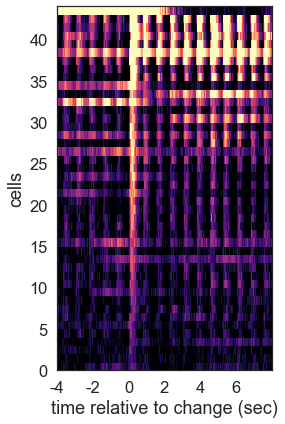

In [40]:
# sort cells in descending order
order = np.argsort(np.max(response_matrix,1))
response_matrix_sorted = response_matrix[order,:]

# create the plot
fig, ax = plt.subplots(figsize=(4,6))
ax.pcolormesh(response_matrix_sorted, cmap='magma', vmin=0, vmax=np.percentile(response_matrix, 95))
ax.set_ylabel('cells')

# fix up the axes
# get the window around the change_time used for trial_response_df creation
trial_response_range = cache.analysis_files_metadata['trial_response_df_params']['window_around_timepoint_seconds']
# ophys frame rate to convert between frames and seconds
ophys_frame_rate = cache.analysis_files_metadata['ophys_frame_rate'] 
# interval in seconds for x-axis labels
x_interval = 2 
# set xticks and xticklabels
ax.set_xticks(np.arange(0, response_matrix.shape[1], x_interval*ophys_frame_rate))
ax.set_xticklabels(np.arange(trial_response_range[0], trial_response_range[1], 2))
ax.set_xlabel('time relative to change (sec)');
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.5: Compute a sparseness metric for one cell</b>

<p>lifetime sparseness is a metric for how selective and sparse a cell's activity is across conditions, bounded between 0 and 1. A high value of this metric indicates high selectivity - a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions. 

<p> 1) Create an array containing the mean response across all flashes for each of the 8 images in the session for one cell. Hint: Use the <code>get_mean_df</code> function introduced in Exercise 2.4 to create a dataframe with the mean response by image for all cells, using the <code>flash_response_df</code>. 
    
<p> 2) Plot this array to visualize the cell's tuning for images. 
    
</div>

In [41]:
fr = session.flash_response_df.copy()

In [42]:
# get mean_df
mean_df = tools.get_mean_df(fr, conditions=['cell_specimen_id', 'image_name'])

Text(0, 0.5, 'mean dF/F')

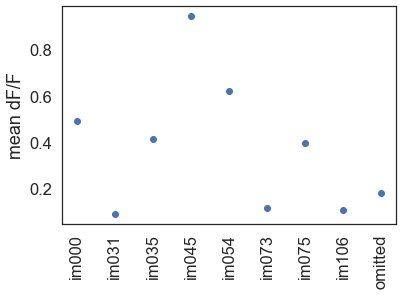

In [43]:
# get array of image responses for one cell
cell_data = mean_df[mean_df.cell_specimen_id==cell_specimen_id]
image_responses = cell_data.mean_response.values
images = cell_data.image_name.values
# plot it
plt.plot(image_responses, 'o')
plt.xticks(np.arange(0,len(images),1), labels=images, rotation=90);
plt.ylabel('mean dF/F')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 2) Provide the image response array to the function below to compute the lifetime sparseness metric for your cell. How selective is this cell? 
    
</div>

In [44]:
def compute_lifetime_sparseness(image_responses):
    # image responses should be an array of the trial averaged responses to each image
    # sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
    # N = number of images
    # after Vinje & Gallant, 2000; Froudarakis et al., 2014
    N = float(len(image_responses))
    ls = ((1-(1/N) * ((np.power(image_responses.sum(axis=0),2)) / (np.power(image_responses,2).sum(axis=0)))) / (1-(1/N)))
    return ls

In [45]:
# compute lifetime sparseness
ls = compute_lifetime_sparseness(image_responses)
print(ls)

0.3874605460982225


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.6: Identify image responsive cells and the mean lifetime sparseness across the population</b>
    
<p> We only want to quantify lifetime sparseness for cells with a significant image response, otherwise we would be including noise in our measurement. Before taking a population average, lets first identify responsive cells. 
    
<p> The <code>p_value</code> column of the <code>flash_response_df</code> is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms after the flash with the activity during the spontaneous activity period. 

<p> Let's define responsive cells as having at least 10% of trials with a <code>p_value</code> < 0.005

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 1) Loop through all cells in the <code>flash_response_df</code>, evaluate the fraction of trials with <code>p_value</code> < 0.005 and make a list of the indicies of responsive cells. Assign the list to a variable called <code>responsive_cells</code>.
                                                                                                              <p> Alternatively, you can use the output of <code>get_mean_df()</code>, which includes a column called <code>fraction_signifiant_responses</code> where this value was computed for each cell for the given conditions. Provide  <code>conditions=['cell_specimen_id']</code> to get the <code>fraction_significant_responses</code> across all images for each cell.
                                                                                                           
<p>What fraction of cells in this experiment were responsive following a stimulus change? 

</div>

In [46]:
# get responsive cells with get_mean_df
mean_df = tools.get_mean_df(session.flash_response_df, conditions=['cell_specimen_id'])
responsive_cells = mean_df[mean_df.fraction_significant_responses>0.01].cell_specimen_id.unique()
print('fraction responsive cells =',len(responsive_cells)/float(len(mean_df.cell_specimen_id.unique())))

fraction responsive cells = 0.9090909090909091


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>2) Loop through each cell in <code>responsive_cells</code>, compute lifetime sparseness as you did above, and add the value to a list. 

<p>3) Convert the list to an array and take the mean. How does the average selectivity across the population compare with your single cell measured in the previous Exercise? 

</div>

In [47]:
# create mean_df for each cell and image pair
mean_fr = tools.get_mean_df(fr, conditions=['cell_specimen_id','image_name'])
# create pandas multi-index
mean_fr = mean_fr.set_index(['cell_specimen_id','image_name'])

# iterate through the responsive cells, and compute lifetime sparseness
all_ls= []
for cell in responsive_cells:
    image_responses =[]
    for i,image in  enumerate(images):
        cell_image = mean_fr.loc[(cell,image)]
        image_responses.append(cell_image.mean_response)        
    ls = compute_lifetime_sparseness(np.array(image_responses))
    all_ls.append(ls) 

In [48]:
# turn into an array and take the mean
all_ls = np.array(all_ls)
np.mean(all_ls)

0.47297826752664196

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Across Session Physiology Exercises</h2>
  
<p>This section deals with comparing neural activity across different experiment sessions, both at the single cell and population level. It also teaches you some neat pandas tricks for reformatting data in useful ways.  
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 3.1: Follow along to learn some useful pandas tricks for multi session data comparison</b>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
One interesting aspect of this dataset is that there are multiple behavior + ophys sessions from each animal. In some cases we might want to perform analyses that compare multiple sessions from the same container to know how behavior or neural responses change with each stage of the task.     

</div>

In [49]:
experiments = cache.experiment_table
experiments.head(15)[['container_id','stage_name','ophys_experiment_id']]

,container_id,stage_name,ophys_experiment_id
0,791352433,OPHYS_1_images_A,792815735
1,791352433,OPHYS_2_images_A_passive,798404219
2,791352433,OPHYS_3_images_A,795073741
3,791352433,OPHYS_4_images_B,795953296
4,791352433,OPHYS_5_images_B_passive,796108483
5,791352433,OPHYS_6_images_B,796308505
6,803517529,OPHYS_1_images_A,806456687
7,803517529,OPHYS_2_images_A_passive,811456530
8,803517529,OPHYS_3_images_A,807752719
9,803517529,OPHYS_4_images_B,808619543


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
From there, we can select two experiment dataframes we wish to analyze from the same container.
</div>

In [50]:
#an active, image_set A dataset
a_trials = cache.get_session(792815735).trials
#an active, image_set B dataset
b_trials = cache.get_session(795953296).trials

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can compare many metrics between these two sessions, as an example, the hit rate between each session using code developed above
</div>

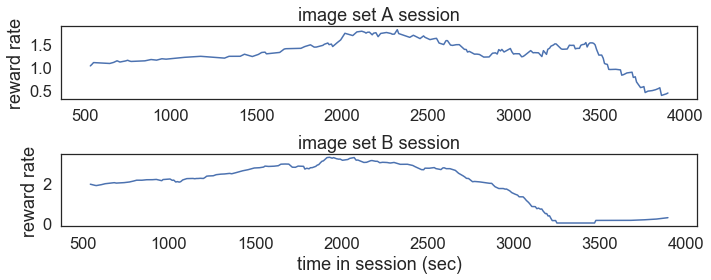

In [51]:
fig, ax = plt.subplots(2,figsize=(10,4))

ax[0].plot(a_trials.change_time, a_trials.reward_rate)
ax[0].set_title('image set A session')
ax[0].set_ylabel ('reward rate')

ax[1].plot(b_trials.change_time, b_trials.reward_rate)
ax[1].set_xlabel ('time in session (sec)')
ax[1].set_title('image set B session')
ax[1].set_ylabel ('reward rate');
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
For more in-depth analysis and to ease plotting, we can merge the two dataframes, passing keys to keep their labels
</div>

In [52]:
a_b = pd.concat([a_trials,b_trials], keys=['a', 'b'])
a_b.head()

initial_image_name change_image_name  change_time  \
  trials_id                                                     
a 0                      im065             im085    310.63261   
  2                      im085             im065    325.64490   
  3                      im065             im063    338.40526   
  4                      im063             im061    350.41502   
  9                      im061             im063    373.68407   

                                                    lick_times  \
  trials_id                                                      
a 0                                                         []   
  2                                                         []   
  3                                                [338.52026]   
  4          [351.26397, 351.73102, 351.88123, 352.01464, 3...   
  9          [374.24944, 374.34953, 374.6664, 374.79984, 37...   

             response_latency  reward_time    go  catch    hit   miss  \
  trials_id                                                             
a 0                       NaN          NaN  True  False  False   True   
  2                       NaN          NaN  True  False  False   True   
  3                   0.11500   338.528713  True  False   True  False   
  4                   0.84895          NaN  True  False  False   True   
  9                   0.56537   374.258100  True  False   True  False   

             false_alarm  correct_reject  aborted  auto_rewarded  \
  trials_id                                                        
a 0                False           False    False          False   
  2                False           False    False          False   
  3                False           False    False          False   
  4                False           False    False          False   
  9                False           False    False          False   

             reward_volume  start_time   stop_time  trial_length  reward_rate  \
  trials_id                                                                     
a 0                  0.000  306.827758  314.851052      8.023294          inf   
  2                  0.000  320.338845  329.863182      9.524337          inf   
  3                  0.007  330.096633  342.624230     12.527597          inf   
  4                  0.000  342.857309  354.633496     11.776187          inf   
  9                  0.007  369.879125  377.902382      8.023257          inf   

             response_binary  
  trials_id                   
a 0                    False  
  2                    False  
  3                     True  
  4                    False  
  9                     True

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Note that looking at the tail lets you see the b trial dataframe that was just merged
</div>

In [53]:
a_b.tail()

initial_image_name change_image_name  change_time lick_times  \
  trials_id                                                                
b 686                    im054             im054   3861.91165         []   
  687                    im054             im045   3870.16860         []   
  688                    im045             im031   3877.67425         []   
  689                    im031             im035   3886.68157         []   
  690                    im035             im035   3894.93829         []   

             response_latency  reward_time     go  catch    hit   miss  \
  trials_id                                                              
b 686                     NaN          NaN  False   True  False  False   
  687                     NaN          NaN   True  False  False   True   
  688                     NaN          NaN   True  False  False   True   
  689                     NaN          NaN   True  False  False   True   
  690                     NaN          NaN  False   True  False  False   

             false_alarm  correct_reject  aborted  auto_rewarded  \
  trials_id                                                        
b 686              False            True    False          False   
  687              False           False    False          False   
  688              False           False    False          False   
  689              False           False    False          False   
  690              False            True    False          False   

             reward_volume   start_time    stop_time  trial_length  \
  trials_id                                                          
b 686                  0.0  3858.857334  3866.113330      7.255996   
  687                  0.0  3866.363403  3874.370113      8.006711   
  688                  0.0  3874.620348  3881.875867      7.255519   
  689                  0.0  3882.125919  3890.883121      8.757202   
  690                  0.0  3891.133307  3899.139885      8.006578   

             reward_rate  response_binary  
  trials_id                                
b 686           0.231025            False  
  687           0.240767            False  
  688           0.250579            False  
  689           0.259528            False  
  690           0.270050            False

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can calculate simple metrics by grouping by the index. In a multi-index dataframe, these can be referenced by their level
</div>

In [54]:
a_b.groupby(level=0).trial_length.mean()

a    8.422605
b    8.582859
Name: trial_length, dtype: float64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can also quickly plot metrics across the two sessions
</div>

Text(0.5, 0, 'image set')

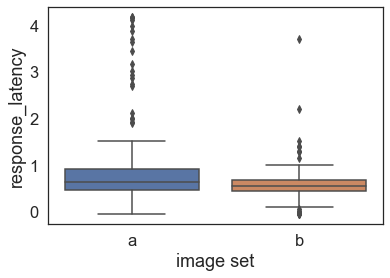

In [55]:
ax = sns.boxplot(data=a_b[a_b.go].reset_index(),x='level_0', y='response_latency')
ax.set_xlabel('image set')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can also get an idea if there are different numbers of trials, in this instance hit trials
</div>

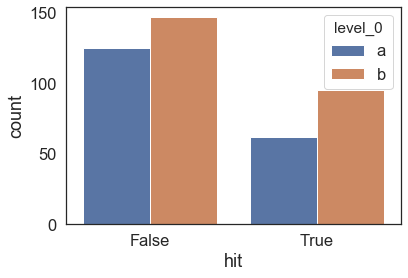

In [56]:
sns.countplot(data=a_b.reset_index()[['level_0','hit']],x='hit',hue='level_0')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> <b>Exercise 3.2: Compare the activity of matched cells across sessions</b>
   
<p> In our experimental design, the same 2-photon field of view is imaged across multiple sessions. A cell may be observed in one or more sessions, dependending on whether or not it is active on different days. Cells that are identified across multiple days have the same 'cell_specimen_id' in all sessions in which they were observed. 
    
<p> To compare activity across multiple sessions, you can use another useful tool provided in the SDK utilities - the <code>create_multi_session_mean_df</code> function.      
    
<p> 1) Run help on  <code>create_multi_session_mean_df</code>. What are its inputs and outputs? 
    
<p> 2) Create a multi session df using the same 2 experiment sessions that were used above (<code>experiment_ids = [792815735, 795953296]</code>) and assign the output to variable called <code>multi_session_df</code>. Set <code>flashes = True</code> to merge across the <code>flash_response_df</code> for the 2 sessions. Note: If <code>flashes = False</code> (the default setting), the function will merge the <code>trial_response_df</code>. 
    
</div>

In [57]:
help(tools.create_multi_session_mean_df)

Help on function create_multi_session_mean_df in module allensdk.brain_observatory.behavior.swdb.utilities:

create_multi_session_mean_df(cache, experiment_ids, conditions=['cell_specimen_id', 'change_image_name'], flashes=False)
    Creates a mean response dataframe by combining multiple sessions. 
    
    INPUTS: 
    cache: the cache object for the dataset
    experiment_ids:  a list of experiment_ids for sessions to merge
    conditions: the set of conditions to group by. The first entry should be 'cell_specimen_id'
    flashes: if TRUE, uses the flash_response_df to merge, otherwise uses the trial_response_df
    
    OUTPUTS
    mega_mdf, a dataframe with index given by the session experiment ids. This allows for easy analysis like:
    mega_mdf.groupby('experiment_id').mean_response.mean()



In [58]:
multi_session_df = tools.create_multi_session_mean_df(cache, [792815735,795953296], flashes=True, conditions=['cell_specimen_id','image_name'])

792815735
795953296


In [59]:
multi_session_df.columns

Index(['cell_specimen_id', 'image_name', 'mean_response', 'sem_response',
       'mean_trace', 'sem_trace', 'mean_responses', 'pref_stim',
       'fraction_significant_responses', 'experiment_id',
       'experiment_container_id', 'stage_name', 'passive', 'image_set',
       'targeted_structure', 'imaging_depth', 'full_genotype', 'cre_line',
       'retake_number'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
By using the <code>groupby()</code> command you can quickly generate comparisons of the same cells across sessions. 
</div>

In [60]:
# get the mean response across images for each experiment session, for each cell_specimen_id
multi_session_df.groupby(['cell_specimen_id','experiment_id'])['mean_response'].mean()

cell_specimen_id  experiment_id
817101771         792815735        0.007166
                  795953296        0.043944
817102086         792815735        0.004083
                  795953296        0.060817
817102331         792815735        0.010413
                                     ...   
817106364         795953296        0.040371
817106409         792815735        0.099075
                  795953296        0.372845
817106446         792815735        0.003420
817106540         792815735        0.004569
Name: mean_response, Length: 93, dtype: float64

<iv style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Using the <code>unstack()</code> command you can regroup these values by cell
    
<p> How can you tell if a cell was identified in both sessions?
</div>

In [61]:
# unstack the grouped dataframe to get each cell's mean_response for different experiments as columns
cell_exp_mean = multi_session_df.groupby(['cell_specimen_id','experiment_id'])['mean_response'].mean()
cell_exp_mean.unstack(level=-1).head()

experiment_id,792815735,795953296
cell_specimen_id,,
817101771,0.007166,0.043944
817102086,0.004083,0.060817
817102331,0.010413,0.149496
817102690,NaN,0.031102
817103270,0.002382,0.009276


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
If the function you want to apply after the <code>groupby()</code> command operates on something other than a numeric value, such as the <code>mean_trace</code> array, you might need to use the <code>.apply(<function>)</code>command. 
    
</div>

In [62]:
# get the mean trace across images for each experiment, for each cell
mean_trace = multi_session_df.groupby(['cell_specimen_id','experiment_id'])['mean_trace'].apply(np.mean)
mean_trace.head()

cell_specimen_id  experiment_id
817101771         792815735        [0.004010978783249945, 0.003488223973397269, 0...
                  795953296        [0.10560597451410975, 0.10087743977257424, 0.0...
817102086         792815735        [0.003444743531799783, 0.003922217684529704, 0...
                  795953296        [0.07181414961357815, 0.06412852734616398, 0.0...
817102331         792815735        [0.01040079791992616, 0.010700414764888398, 0....
Name: mean_trace, dtype: object

In [63]:
# unstack to get experiments as columns
mean_trace = mean_trace.unstack(level=-1)
mean_trace.head()

experiment_id,792815735,795953296
cell_specimen_id,,
817101771,"[0.004010978783249945, 0.003488223973397269, 0...","[0.10560597451410975, 0.10087743977257424, 0.0..."
817102086,"[0.003444743531799783, 0.003922217684529704, 0...","[0.07181414961357815, 0.06412852734616398, 0.0..."
817102331,"[0.01040079791992616, 0.010700414764888398, 0....","[0.1982543543187626, 0.1938140392847128, 0.184..."
817102690,NaN,"[0.08536135827222638, 0.07378677899854758, 0.0..."
817103270,"[0.001835434698643429, 0.0012437035472362716, ...","[0.015592967691291962, 0.01391044363836151, 0...."


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 3) Use the <code>mean_trace</code> dataframe generated above to plot the dF/F trace for one cell across the 2 experiment sessions. Include the <code>experiment_id</code> that each trace came from in the figure legend. Make sure it is a cell that has a <code>mean_trace</code> in both sessions. 
    
<p> How does the response differ across days? 
    
</div>

In [64]:
mean_trace.head()

experiment_id,792815735,795953296
cell_specimen_id,,
817101771,"[0.004010978783249945, 0.003488223973397269, 0...","[0.10560597451410975, 0.10087743977257424, 0.0..."
817102086,"[0.003444743531799783, 0.003922217684529704, 0...","[0.07181414961357815, 0.06412852734616398, 0.0..."
817102331,"[0.01040079791992616, 0.010700414764888398, 0....","[0.1982543543187626, 0.1938140392847128, 0.184..."
817102690,NaN,"[0.08536135827222638, 0.07378677899854758, 0.0..."
817103270,"[0.001835434698643429, 0.0012437035472362716, ...","[0.015592967691291962, 0.01391044363836151, 0...."


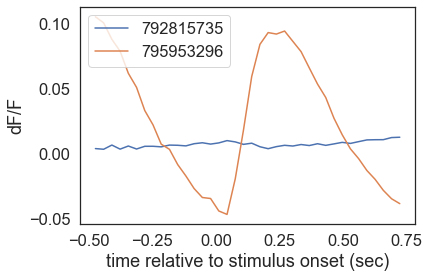

In [65]:
cell_data = mean_trace.iloc[0]
# hacky way to get timestamps for now
flash_timestamps = session.flash_response_df.iloc[0]['dff_trace_timestamps'] - session.flash_response_df.iloc[0]['start_time']
for experiment_id in cell_data.keys():
    plt.plot(flash_timestamps, cell_data[experiment_id], label=str(experiment_id))
plt.legend(loc='upper left');
plt.xlabel('time relative to stimulus onset (sec)');
plt.ylabel('dF/F');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> <b>Exercise 3.3: Merge all the experiments from a single container and plot the mean response for different image sets</b>   
    
<p> 1) Get all experiment_ids for a single container_id. 

<p> 2) Merge the trial_response_dfs across sessions using <code>create_multi_session_mean_df</code> and assign the output to 'container_trial_mean_df'. 
</div>

In [66]:
# get experiment_ids for one container
experiment_ids = experiments[experiments.container_id == 803517529].ophys_experiment_id.values

In [67]:
# create multi_session dataframe with experiments from this container
container_trial_mean_df = tools.create_multi_session_mean_df(cache, experiment_ids)

806456687
811456530
807752719
808619543
813083478


In [68]:
# group by experiment_id and stage_name to get the mean response across different session types
container_trial_mean_df.groupby(['experiment_id','stage_name']).mean_response.mean()

experiment_id  stage_name              
806456687      OPHYS_1_images_A            0.040677
807752719      OPHYS_3_images_A            0.047659
808619543      OPHYS_4_images_B            0.062216
811456530      OPHYS_2_images_A_passive    0.039349
813083478      OPHYS_6_images_B            0.051875
Name: mean_response, dtype: float64

In [69]:
# group by experiment_id and image_set to get the mean response across different image sets
container_trial_mean_df.groupby(['experiment_id','image_set']).mean_response.mean()

experiment_id  image_set
806456687      A            0.040677
807752719      A            0.047659
808619543      B            0.062216
811456530      A            0.039349
813083478      B            0.051875
Name: mean_response, dtype: float64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">    
<p> 3) Plot the mean response for image set A vs. image set B for each cell as a scatter plot. Hint: use <code>groupby()</code> and <code>unstack()</code> as demonstrated above to make it more efficient. 
</div>

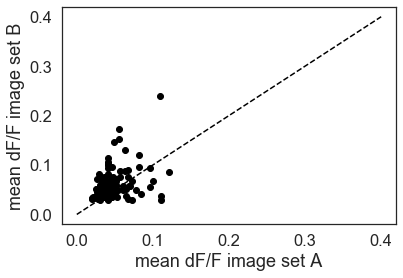

In [70]:
# ineffient but intuitive way
fig, ax = plt.subplots()
for cell_specimen_id in container_trial_mean_df.cell_specimen_id.unique():
    df = container_trial_mean_df[container_trial_mean_df.cell_specimen_id==cell_specimen_id].copy()
    a_response = df[df.image_set=='A'].mean_response.mean()
    b_response = df[df.image_set=='B'].mean_response.mean()
    ax.plot(a_response, b_response, 'ok')
ax.plot([0,0.4],[0,0.4],'k--')
ax.set_xlabel('mean dF/F image set A');
ax.set_ylabel('mean dF/F image set B');

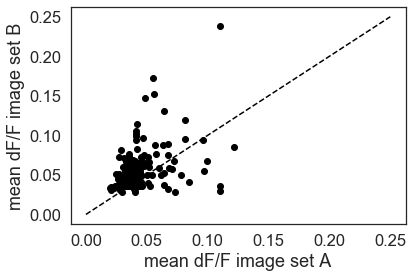

In [71]:
# efficient pandas magic way
# plot the mean response of each cell to image set A vs image set B
cell_image = container_trial_mean_df.groupby(['cell_specimen_id','image_set']).mean_response.mean().unstack(level=1)
plt.plot(cell_image.values[:,0],cell_image.values[:,1],'ko')
plt.plot([0,0.25],[0,0.25],'k--');
plt.xlabel('mean dF/F image set A');
plt.ylabel('mean dF/F image set B');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">    
<p> 4) Plot the population average trace across cells for image set A vs. image set B using the values of the <code>mean_trace</code> column. Indicate the image set for each trace in a figure legend. 
<p> Bonus: plot the x-axis in seconds. 
<p> Which image set evokes stronger activity across the population? 
</div>

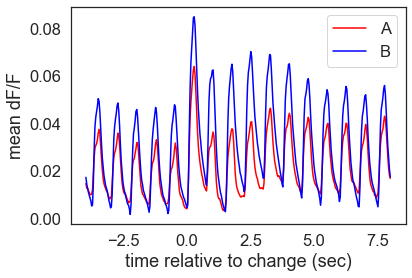

In [72]:
# solution method 1
fig, ax = plt.subplots()
df = container_trial_mean_df.copy()
# get population average trace for both image sets
a_response = df[df.image_set=='A'].mean_trace.mean()
b_response = df[df.image_set=='B'].mean_trace.mean()
# get timestamps to plot
tr = session.trial_response_df.copy()
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
# plot both traces
ax.plot(timestamps, a_response, color='r', label='A')
ax.plot(timestamps, b_response, color='b', label='B')
plt.xlabel('time relative to change (sec)')
plt.ylabel('mean dF/F')
plt.legend();

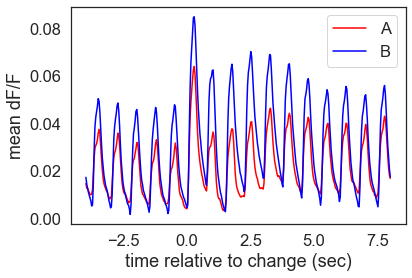

In [73]:
# solution method 2
# plot the average trace for all cells by image_set
image_set_trace= container_trial_mean_df.groupby('image_set').mean_trace.apply(np.mean)
tr = session.trial_response_df.copy()
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
plt.plot(timestamps, image_set_trace.loc['A'],'r',label='A')
plt.plot(timestamps, image_set_trace.loc['B'],'b',label='B')
plt.xlabel('time relative to change (sec)')
plt.ylabel('mean dF/F')
plt.legend();

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 3.4: Plot the trial averaged response for passive vs. active sessions from one container</b>
   
<p> Use the pandas skills learned above to plot the mean response on passive vs. active sessions. 
    
<p> 1) Plot the cell by cell mean response for passive vs. active as a scatterplot. Use the <code>passive</code> column of the <code>container_trial_mean_df</code> dataframe to differentiate passive vs. active.  
</div>

In [74]:
# mean across the entire session
container_trial_mean_df.groupby('passive').mean_response.mean()

passive
False    0.050341
True     0.039349
Name: mean_response, dtype: float64

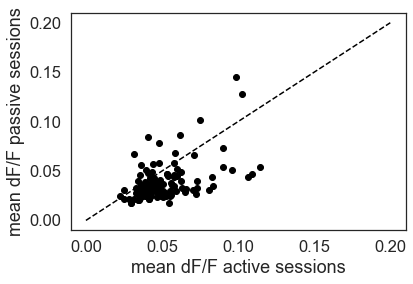

In [75]:
# cell by cell plot
cell_passive = container_trial_mean_df.groupby(['cell_specimen_id','passive']).mean_response.mean().unstack(level=1)
plt.plot(cell_passive.values[:,0],cell_passive.values[:,1],'ko')
plt.plot([0,0.2],[0,0.2],'k--');
plt.xlabel('mean dF/F active sessions');
plt.ylabel('mean dF/F passive sessions');

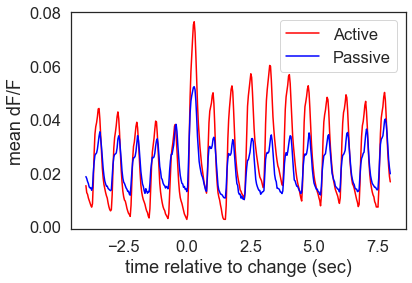

In [76]:
# plot the average trace across all cells by active/passive
passive = container_trial_mean_df.groupby('passive').mean_trace.apply(np.mean)
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
plt.plot(timestamps,passive.loc[False],'r',label='Active')
plt.plot(timestamps,passive.loc[True],'b',label='Passive')
plt.xlabel('time relative to change (sec)')
plt.ylabel('mean dF/F')
plt.legend()